Про <a href="https://devmems.ru/library/article/28">os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'</a>.

CUDA для GPU TensorFlow. 

Для распознавания графических образов хорошо себя показали свёрточные нейронные сети.

Каждый раз при решении задачи с помощью нейронных сетей приходится определять:
1. Структура НС;
2. Способ оптимизации алгоритма градиентного спуска ('adam', 'sgd', остальные);

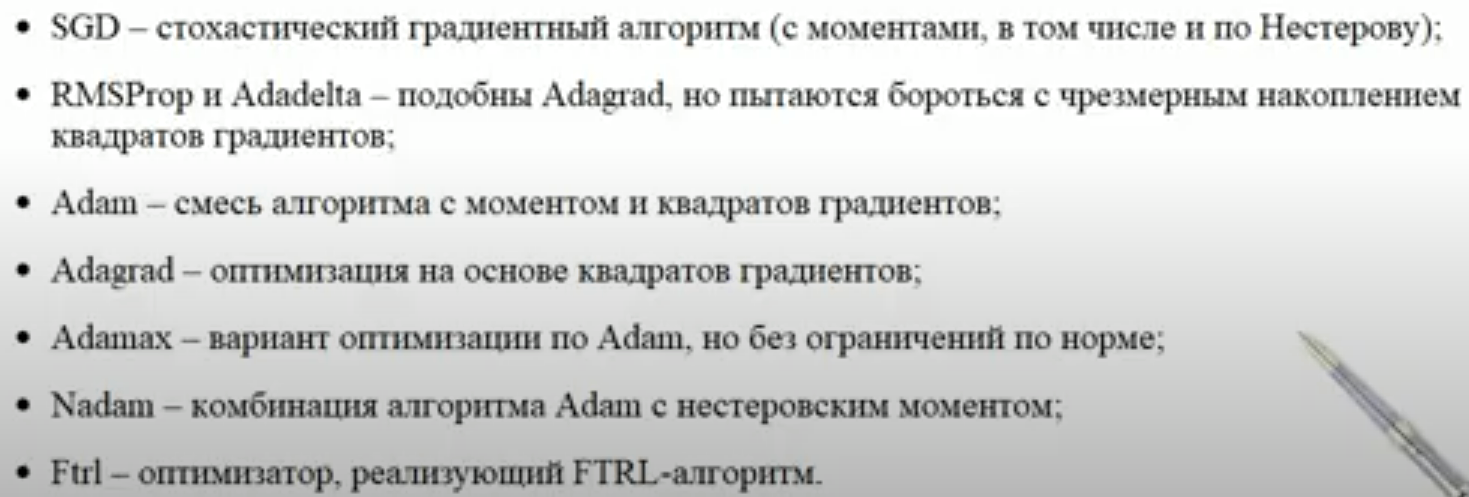

3. Критерий качества;
4. Способ формирования выборки валидации из обучающего множества.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras import backend as K

# Бэкенд — это термин в Keras, который выполняет все низкоуровневые вычисления,
# такие как тензорные произведения, свертки и многое другое, с помощью других библиотек, таких как Tensorflow или Theano.

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D  # , GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
# from keras.layers import AvgPool2D, MaxPool2D
# from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

from PIL import Image, ImageDraw

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

D:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Про набор данных можно прочитать <a href="https://github.com/Deepwise-AILab/ChestX-Det-Dataset">здесь</a>.

In [2]:
import json

d_train = dict()
with open('ChestX_Det_train.json', 'r', encoding='utf-8') as f:
    reader = json.load(f)
    for r in reader:
        if set(r['syms']) == set():
            d_train[r['file_name']] = {'syms': ('Normal',), 'boxes': list()}
        else:
            cat = tuple(set(r['syms']))
            d_train[r['file_name']] = {'syms': cat, 'boxes': list()}
            for i in range(len(cat)):
                d_train[r['file_name']]['boxes'].append(r['boxes'][i])

Общее количество классов, на которые делятся все изображения.

In [3]:
NB_CLASSES = 13 + 1

Определим наибольшие значения высоты и ширины указанных на изображении областей.

In [4]:
h = 0
w = 0
for v in d_train.values():
    if v['boxes']:
        for box in v['boxes']:
            a = abs(box[0] - box[2]) 
            b = abs(box[1] - box[3])
            if a > w:
                w = a   
            if b > h:
                h = b

In [5]:
h, w

(915, 603)

Следовательно, изображения областей можно подвергать процедуре padding'а до размера 915×915 пикселей.

Изображения, на которых нет выделенных областей, будем искусственно обрезать до указанного размера.

In [ ]:
img = Image.open('C:/Users/37529/Documents/Coursework 3/data/train_data/train/36200.png')
draw = ImageDraw.Draw(img)
draw.rectangle([1024 - h, h, h, 1024 - h], outline='white')

img.show()

Посмотрим на изображения, где представлена область.

In [ ]:
img = Image.open('C:/Users/37529/Documents/Coursework 3/data/train_data/train/36209.png')
draw = ImageDraw.Draw(img)
draw.rectangle([1024 - h, h, h, 1024 - h], outline='white')
draw.rectangle(d_train['36209.png']['boxes'][0], outline='white')

img.show()

In [ ]:
img = Image.new('rgb'.upper(), (1024, 1024), (255, 255, 255))

png = Image.open('C:/Users/37529/Documents/Coursework 3/data/train_data/train/36209.png')
crop = png.crop(d_train['36209.png']['boxes'][0])
img.paste(crop, d_train['36209.png']['boxes'][0][:2])

c = img.crop([1024 - h, 1024 - h, h, h])
c.show()

Проведём данную процедуру с изображениями каждого класса, предварительно написав функцию. Важно отметить, что область при таком подходе помещается в центр нового изображения. Возможно, стоит продумать ситуацию, при которой область останется на своём месте.

In [6]:
def image_new_method(name: str, d_data: dict):
    png = Image.open(name)
    if d_data[name]['boxes']:
        for box, sym in zip(d_data[name]['boxes'], d_data[name]['syms']):
            img = Image.new('rgb'.upper(), (1024, 1024), (255, 255, 255))
            crop = png.crop(box)
            img.paste(crop, box[:2])
            new = img.crop([1024 - h, 1024 - h, h, h])
            new.save(name[:-4] + f'_{sym}.png')
    else:
        crop = png.crop([1024 - h, 1024 - h, h, h])
        crop.save(name[:-4] + '_Normal.png')
    os.remove(name)

Обработаем изображения обучающей выборки.

In [7]:
train_directory = 'C:/Users/37529/Documents/Coursework 3/data/train_data/train'
os.chdir(train_directory)

In [ ]:
for k in d_train.keys():
    image_new_method(k, d_train)

Сформируем валидационную выборку, поместив туда 20% обучающих данных.

In [8]:
val_directory = 'C:/Users/37529/Documents/Coursework 3/data/val_data/val'

In [ ]:
imgs = os.listdir()
random.shuffle(imgs)

for img in imgs[:int(len(imgs)*.2)]:
    f_name = img.split('_')[-1][:-4]
    if not os.path.isdir(val_directory + '/' + f_name):
        os.mkdir(val_directory + '/' + f_name)
    to = val_directory + '/' +  f_name + '/' + img
    os.replace(img, to)

**Важно подчеркнуть, что данные именно перемещались!**

Создадим структуру папок с названиями классов в обучающей выборке.

In [ ]:
for i in os.listdir():
    f_name = i.split('_')[-1][:-4]
    if not os.path.isdir(f_name):
        os.mkdir(f_name) 
    to = f_name + '/' + i
    os.replace(i, to)

Проделаем аналогичные процедуры с тестовыми изображениями.

In [9]:
cur_directory = 'C:/Users/37529/Documents/Coursework 3/Test'
os.chdir(cur_directory)

In [10]:
d_test = dict()
with open('ChestX_Det_test.json', 'r', encoding='utf-8') as f:
    reader = json.load(f)
    for r in reader:
        if set(r['syms']) == set():
            d_test[r['file_name']] = {'syms': ('Normal',), 'boxes': list()}
        else:
            cat = tuple(set(r['syms']))
            d_test[r['file_name']] = {'syms': cat, 'boxes': list()}
            for i in range(len(cat)):
                d_test[r['file_name']]['boxes'].append(r['boxes'][i])

In [ ]:
test_directory = 'C:/Users/37529/Documents/Coursework 3/data/test_data/test'
os.chdir(test_directory)

for k in d_test.keys():
    image_new_method(k, d_test)

In [ ]:
for i in os.listdir():
    f_name = i.split('_')[-1][:-4]
    if not os.path.isdir(f_name):
        os.mkdir(f_name) 
    to = f_name + '/' + i
    os.replace(i, to)

Как оптимально подобрать количество эпох обучения и параметр `BATCH_SIZE`?

Как выбираем <a href="https://stackoverflow.com/questions/56320749/how-to-choose-batch-size-steps-per-epoch-and-epoch-with-keras-generator">BATCH_SIZE</a>?

In [11]:
BATCH_SIZE = 32

Как выбираем EPOCHS?

Предварительно установим значение 8.

In [12]:
EPOCHS = 8

Подготовка изображений для обучения.

О параметрах конструктора класса <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator">ImageDataGenerator</a>:
- **shear_range** позволяет случайным образом искривлять изображения путем изменения угла наклона объектов на изображении: каждая точка изображения перемещается вдоль одной из осей. Изменение угла наклона может быть полезным, если данные содержат объекты, наклоненные под разными углами, с целью обучения модели на изображениях с различными наклонами.
- **zoom_range** случайным образом масштабирует изображения.
- **horizontal_flip** случайным образом горизонтально отражает входные данные.

<a href="https://www.educba.com/keras-imagedatagenerator/">Туториал</a> по использованию этого класса.

In [13]:
datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True
)

О методе flow_from_directory.

Метод **flow_from_directory** класса ImageDataGenerator предоставляет возможность генерировать пакеты данных (batch) из изображений, хранящихся в определенной директории. Вместо загрузки всех изображений в память сразу, этот метод позволяет загружать данные порциями (пакетами) по мере необходимости.

<a href="https://pythonru.com/osnovy/rabota-s-fajlami-v-python-s-pomoshhju-modulja-os">Краткий экскурс в работу с библиотекой os.</a>

Реализуем генераторные функции для обучения.

<a href="https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720">Подробнее</a> про метод flow_from_directory.

In [14]:
train_generator = datagen.flow_from_directory(
    directory=train_directory,
    target_size=(512, 512),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=0
)

Found 4570 images belonging to 14 classes.


In [15]:
validation_generator = datagen.flow_from_directory(
    directory=val_directory, 
    target_size=(512, 512),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=0
)

Found 1142 images belonging to 14 classes.


Спроектируем архитектуру полносвязной нейронной сети с одним скрытым слоем.

In [16]:
model = Sequential([
    Flatten(input_shape=(h, h)),
    Dense(128, activation='relu'),
    Dense(NB_CLASSES, activation='softmax')
])

**Sequential** создаёт модель многослойной нейронной сети.

**Dense** создаёт слой нейронов полносвязной нейронной сети.

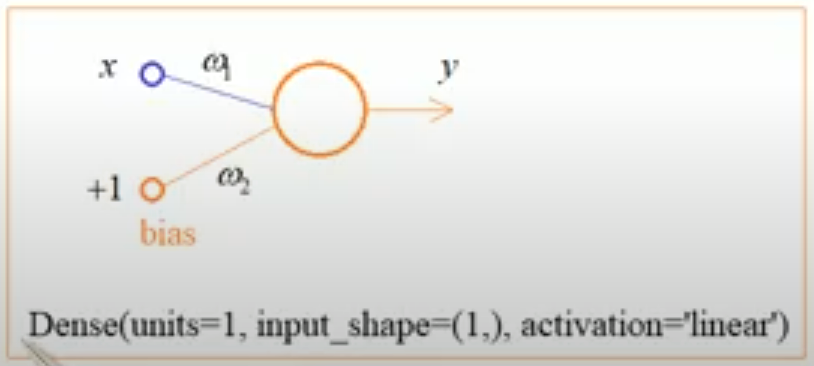

* units $-$ количество нейронов;
* input_shape $-$ количество входов;
* activation $-$ функция активации.

Для добавления слоя в модель необходимо использовать метод **add**.

Для компиляции модели используем метод **compile** с параметрами 
* loss $-$ функция потерь;
* optimizer $-$ оптимизатор для алгоритма градиетного спуска.
При компиляции модели весам присваиваются некоторые случайные значения.

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Метод **fit** используется для обучения модели.

Метод **predict**, в свою очередь, $-$ для применения модели.

Для получения весовых коэффициентов модели используется метод **get_weights**.

При построении архитектуры нейронной сети разработчик опирается, преимущественно, на свою интуицию. 

Попробуем решить задачу с использованием полносвязной нейронной сети, аналогично примеру.

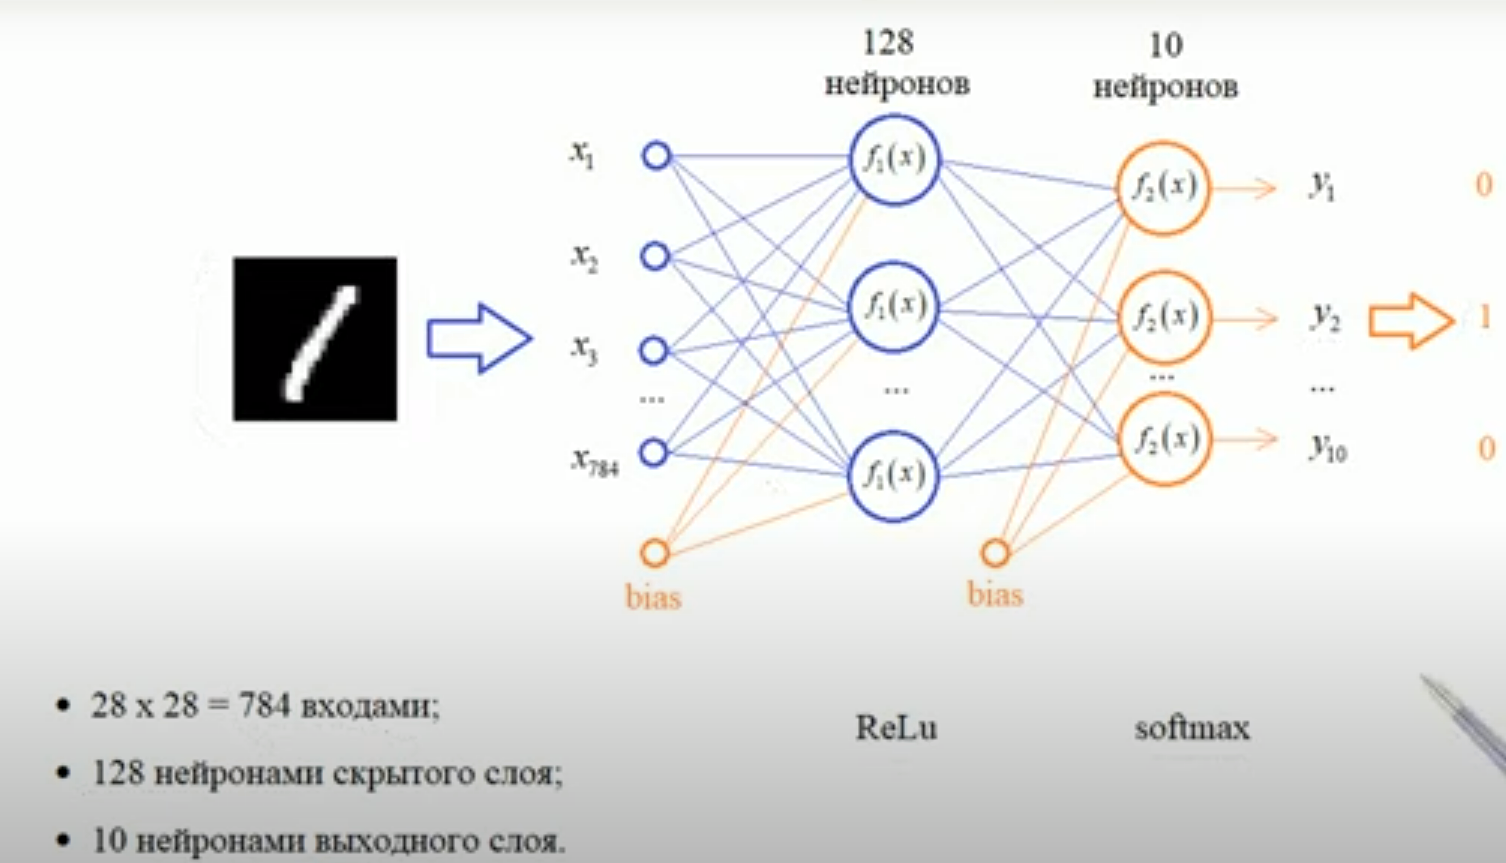

Слой **Flatten** позволяет преобразовать матрицу в вектор.

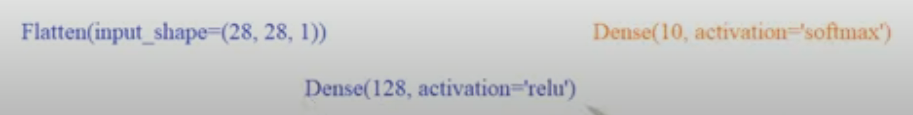

* input_shape $-$ тройка (x, y, z), где x $-$ ширина изображения, y $-$ высота изображения, z $-$ цвет (для ч/б изображений указывается 1).

Метод **summary** показывает структуру нейронной сети (param $-$ веса).

Для этой задачи в качестве функции потерь выгоднее использовать категориальную кросс-энтропию.

В действительности при решении задачи классификации важно не значение кросс-энтропии, а процент правильно распознанных изображений. Построить алгоритм, который бы минимизировал именно процент ошибок, сложно (если вообще возможно), поэтому разработчики привязываются к более простому с точки зрения математики критерию, минимизируя который, надеятся минимизировать процент ошибок, что в среднем и происходит. 

Метод **evaluate** позволит оценить обученную модель на тестовой выборке.

Полезная <a href="https://medium.com/codex/master-keras-imagedatagenerator-class-989ea21fc489">статья</a> про обучение с помощью генераторов.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 837225)            0         
                                                                 
 dense (Dense)               (None, 128)               107164928 
                                                                 
 dense_1 (Dense)             (None, 14)                1806      
                                                                 
Total params: 107166734 (408.81 MB)
Trainable params: 107166734 (408.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/8


143/143 [==============================] - 409s 3s/step - loss: 124.9635 - accuracy: 0.1571 - val_loss: 2.6198 - val_accuracy: 0.2356
Epoch 2/8
143/143 [==============================] - 407s 3s/step - loss: 3.8518 - accuracy: 0.2359 - val_loss: 2.5752 - val_accuracy: 0.2356
Epoch 3/8
143/143 [==============================] - 425s 3s/step - loss: 2.5577 - accuracy: 0.2363 - val_loss: 2.5292 - val_accuracy: 0.2356
Epoch 4/8
143/143 [==============================] - 416s 3s/step - loss: 2.5161 - accuracy: 0.2363 - val_loss: 2.4860 - val_accuracy: 0.2356
Epoch 5/8
143/143 [==============================] - 410s 3s/step - loss: 2.4785 - accuracy: 0.2363 - val_loss: 2.4473 - val_accuracy: 0.2356
Epoch 6/8
143/143 [==============================] - 404s 3s/step - loss: 4.0677 - accuracy: 0.2361 - val_loss: 2.4138 - val_accuracy: 0.2356
Epoch 7/8
143/143 [==============================] - 401s 3s/step - loss: 2.4175 - accuracy: 0.2363 - val_loss: 2.3850 - val_accuracy: 0.2356
Ep

Обучение полносвязной НС неэффективно, поэтому стоит попробовать классический подход $-$ построение свёрточной НС.

Свёрточные НС были спроектированы на основе биологической зрительной системы.

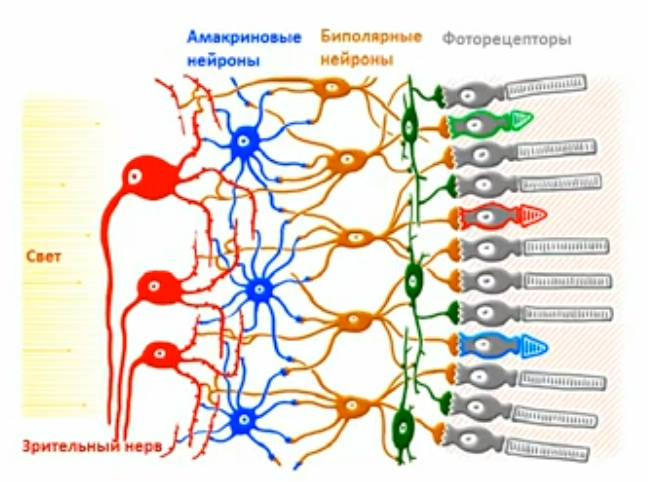

Математическое обобщение.

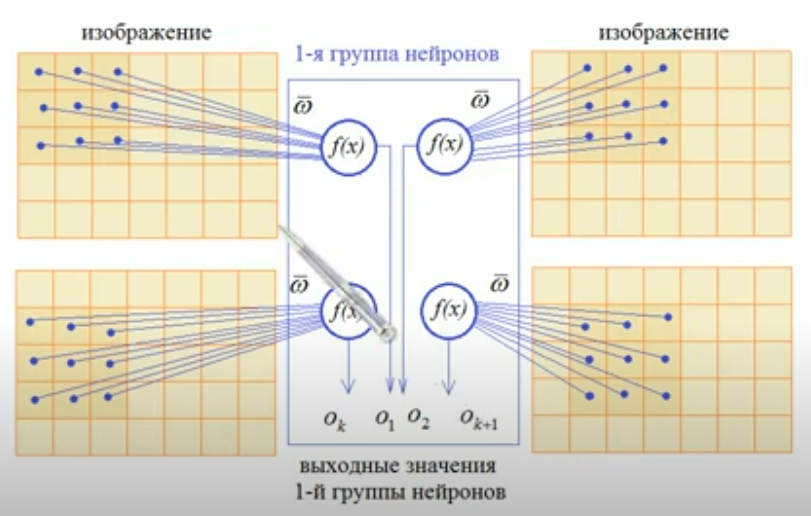

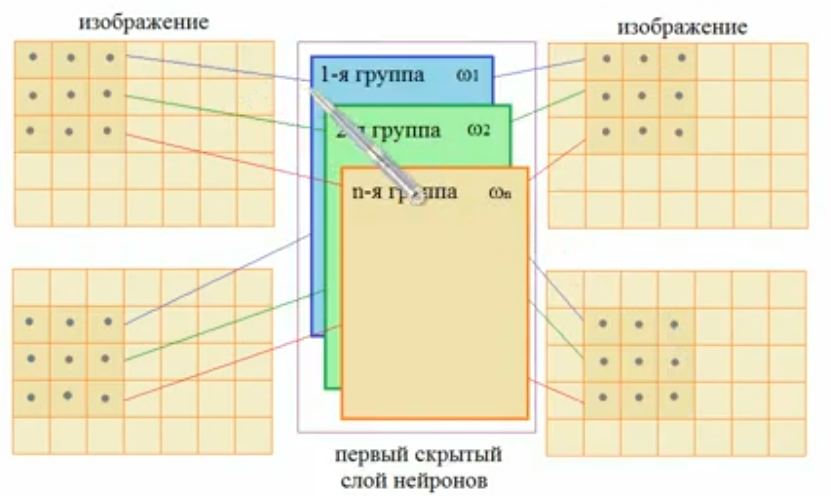

Про свёртку и импульсный отклик фильтра (ядро фильтра). Ядро фильтра имеет одни и те же весовые коэффициенты.

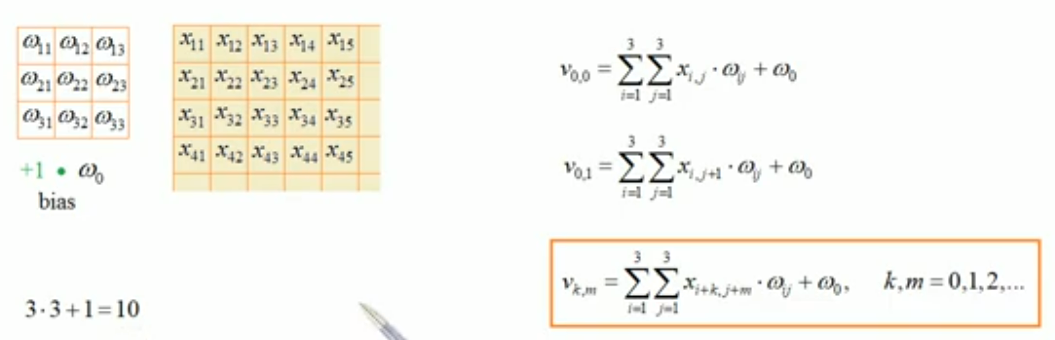

Для каждой группы нейронов формируется канал. Каждая группа нейронов отвечает за определённую геометрию изображения.

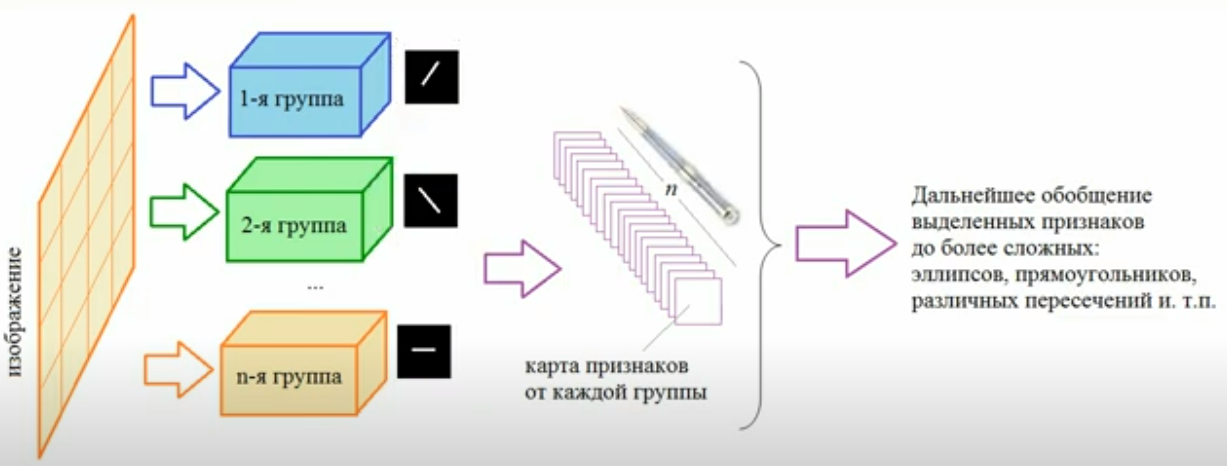

Pooling (изменение масштаба):

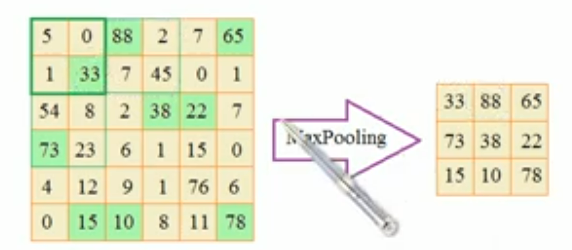

* MaxPooling;
* MinPooling;
* AvgPooling.

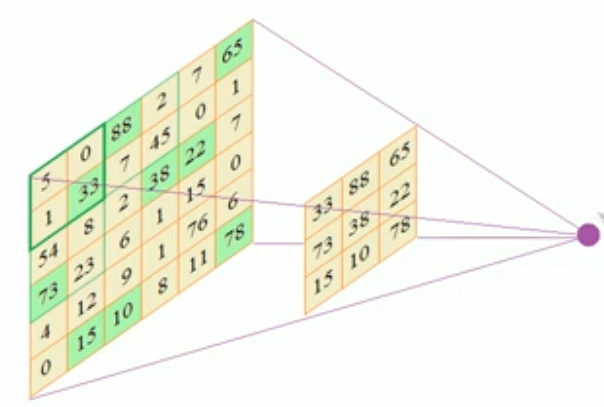

Пример архитектуры свёрточной НС. Обычно, свёрточная НС завершается полносвязными слоями.

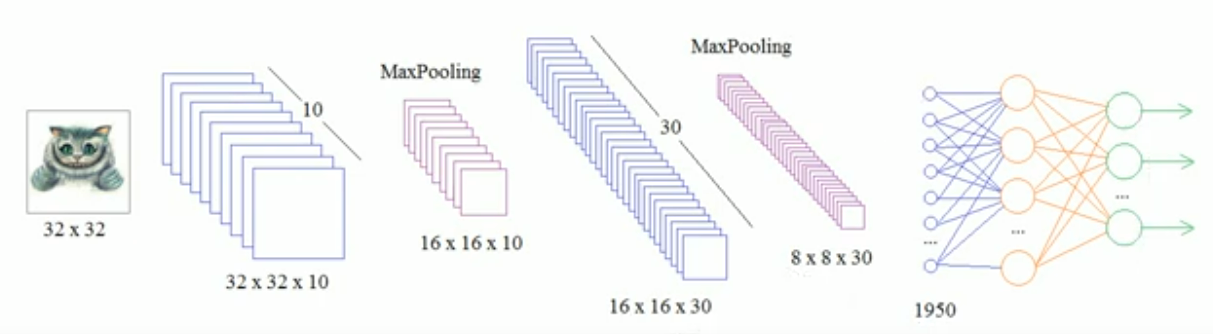

Как строить свёрточную НС в keras?

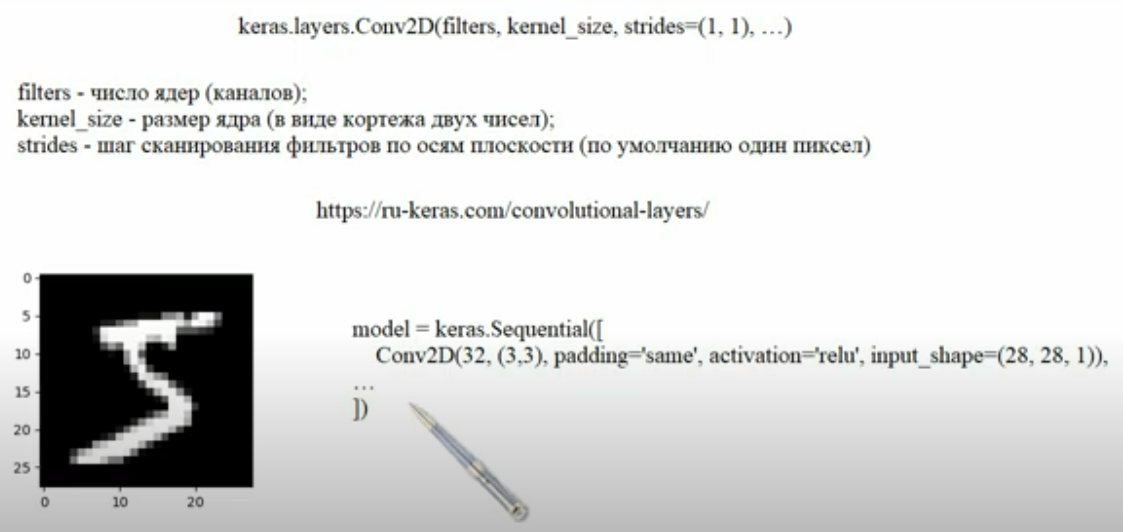

padding='same'.

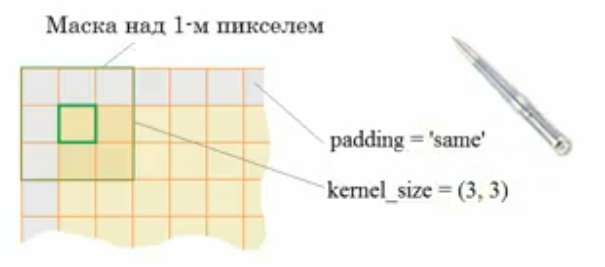

MaxPooling.

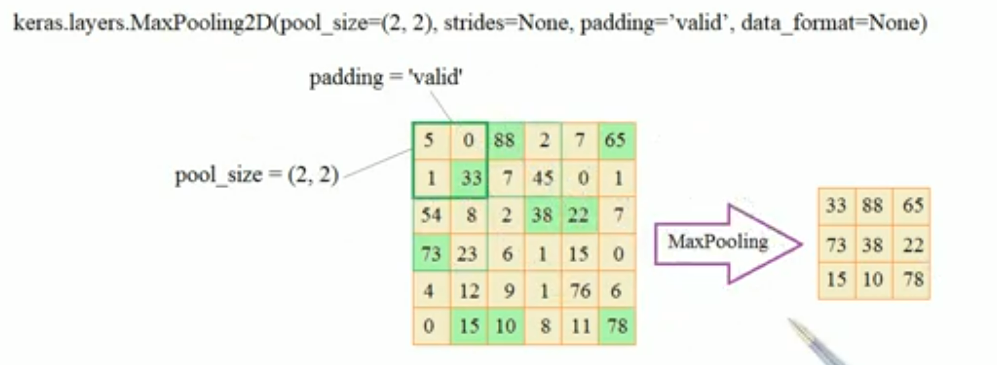

Как вычисляются коэффициенты?

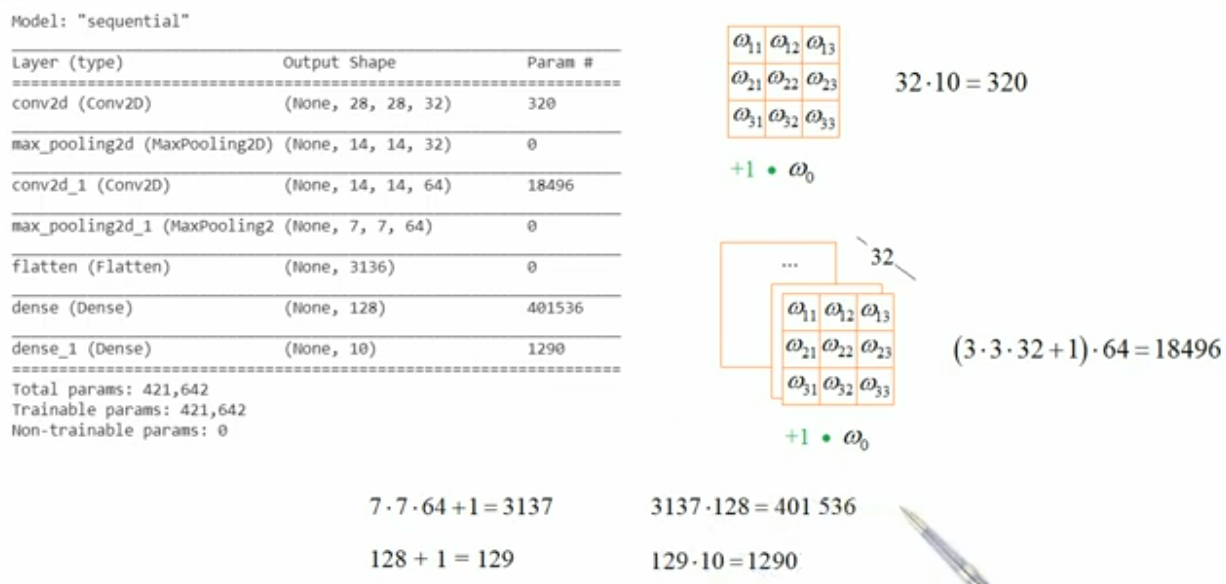

Спроектируем архитектуру свёрточной НС.

In [16]:
cnn = Sequential([
    Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(512, 512, 1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(64, (6, 6), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NB_CLASSES, activation='softmax')
])

In [17]:
cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [18]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      147520    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               1

In [19]:
cnn_history = cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/8


143/143 [==============================] - 1450s 10s/step - loss: 3.3659 - accuracy: 0.2363 - val_loss: 2.1880 - val_accuracy: 0.2767
Epoch 2/8
143/143 [==============================] - 1246s 9s/step - loss: 2.1773 - accuracy: 0.2908 - val_loss: 2.1177 - val_accuracy: 0.2968
Epoch 3/8
143/143 [==============================] - 1235s 9s/step - loss: 2.1587 - accuracy: 0.2899 - val_loss: 2.0599 - val_accuracy: 0.3205
Epoch 4/8
143/143 [==============================] - 1235s 9s/step - loss: 2.0873 - accuracy: 0.3177 - val_loss: 1.9848 - val_accuracy: 0.3310
Epoch 5/8
143/143 [==============================] - 1273s 9s/step - loss: 2.1957 - accuracy: 0.2772 - val_loss: 2.1843 - val_accuracy: 0.2846
Epoch 6/8
143/143 [==============================] - 1281s 9s/step - loss: 2.3451 - accuracy: 0.2499 - val_loss: 2.1918 - val_accuracy: 0.2793
Epoch 7/8
143/143 [==============================] - 1274s 9s/step - loss: 2.2410 - accuracy: 0.2663 - val_loss: 2.2519 - val_accuracy: 0.2

In [21]:
os.getcwd()

'C:\\Users\\37529\\Documents\\Coursework 3\\Test'

In [32]:
os.chdir(train_directory)
for f in os.listdir():
    print(f'{f}: {len(list(os.walk(f))[0][-1])}')

Atelectasis: 201
Calcification: 129
Cardiomegaly: 190
Consolidation: 1080
Diffuse Nodule: 111
Effusion: 923
Emphysema: 107
Fibrosis: 330
Fracture: 248
Mass: 89
Nodule: 264
Normal: 442
Pleural Thickening: 327
Pneumothorax: 129


Разделим 14 классов на 2 группы по 7. Причём НС будет отвечать, принадлежит ли входное изображение одному из 7 представленных классов или нет (8 класс).

Разделим изображения, опираясь на схожесть их рентгеновских снимков.
Согласно данным, предоставленным <a href="https://mistral.ai/news/le-chat-mistral/">языковой моделью</a>, представленные 14 классов можно разделить следующим образом:
1. Заболевания, характеризующиеся изменениями в легочной ткани или нарушением ее структуры:
* **Atelectasis** (ателектаз) - спадание легочной ткани с образованием плотных участков;
* **Consolidation** (консолидация) - сплощение легочной ткани, обычно вызванное инфекцией или накоплением жидкости;
* **Emphysema** (эмфизема) - хроническое заболевание, характеризующееся разрушением альвеол и увеличением объема легких;
* **Fibrosis** (фиброз) - замещение нормальной легочной ткани рубцовой соединительной тканью;
* **Mass** (опухоль) - появление аномального роста ткани в легких, который может быть доброкачественным или злокачественным;
* **Nodule** (узел) - небольшое округлое или овальное образование в легочной ткани;
* **Diffuse Nodule** (диффузные узелки) - множественные узелки, распространенные по всей легочной ткани.
2. Заболевания, характеризующиеся изменениями в плевральной полости или нарушением нормального состояния легких:
* **Calcification** (кальцификация) - отложение солей кальция в легочной ткани или плевральной полости;
* **Cardiomegaly** (кардиомегалия) - увеличение сердца, которое может влиять на легкие и их функционирование;
* **Effusion** (выпот) - накопление жидкости в плевральной полости;
* **Pleural Thickening** (утолщение плевры) - утолщение плевральной оболочки, которая покрывает легкие и грудную клетку;
* **Pneumothorax** (пневмоторакс) - накопление воздуха в плевральной полости, вызывающее коллапс легкого;
* **Fracture** (перелом ребра) - перелом одного или нескольких ребер, который может повлиять на функционирование легких;
* **Normal** (нормальные легкие) - отсутствие каких-либо патологических изменений на рентгеновских снимках легких.

In [33]:
201 + 1080 + 107 + 330 + 89 + 264 + 111

2182

In [34]:
129 + 190 + 923 + 327 + 129 + 248 + 442

2388

Изображения распределились примерно равномерно.

In [39]:
other_one_directory = 'C:/Users/37529/Documents/Coursework 3/data/two classes/model one/Other'

n = 50
os.chdir(other_one_directory)
for f in os.listdir():
    imgs = tuple(os.walk(f))[0][-1]
    random.shuffle(imgs)
    [os.replace(f + '/' + i, other_one_directory + '/' + i) for i in imgs[:n]]

In [40]:
other_two_directory = 'C:/Users/37529/Documents/Coursework 3/data/two classes/model two/Other'

os.chdir(other_two_directory)
for f in os.listdir():
    imgs = tuple(os.walk(f))[0][-1]
    random.shuffle(imgs)
    [os.replace(f + '/' + i, other_two_directory + '/' + i) for i in imgs[:n]]

Попробуем обучить сеть с архитектурой VGG-16.

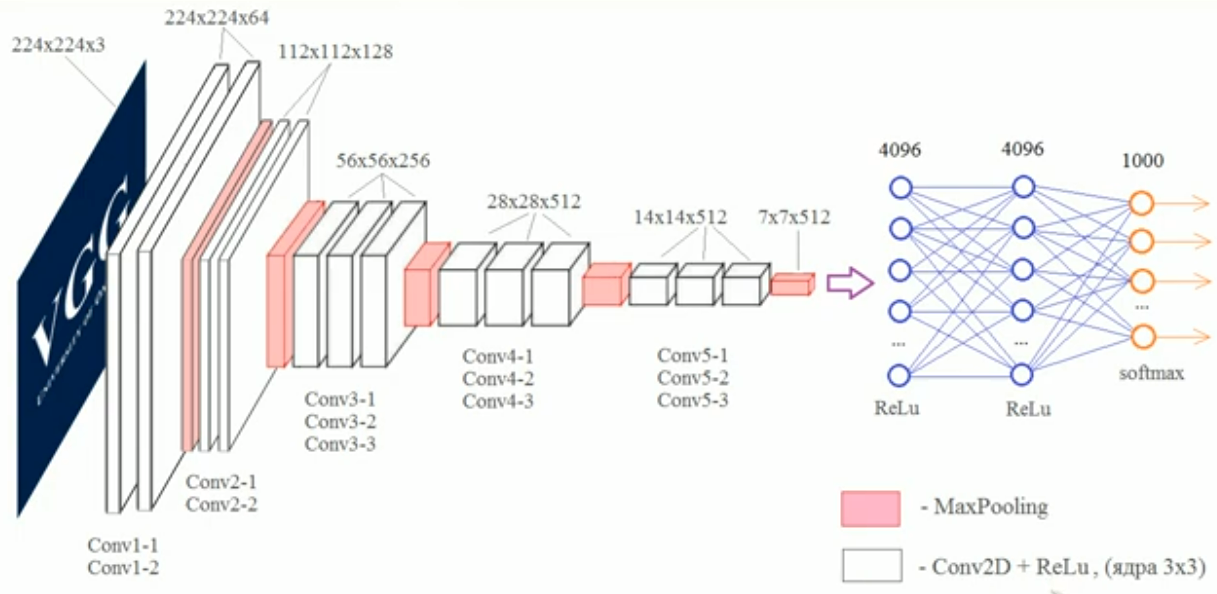

Для чего идут подряд несколько свёрточных слоёв?

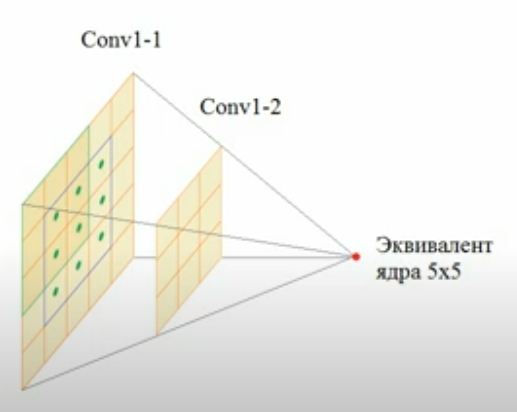

Сети VGG-16 и VGG-19 в пакете keras.

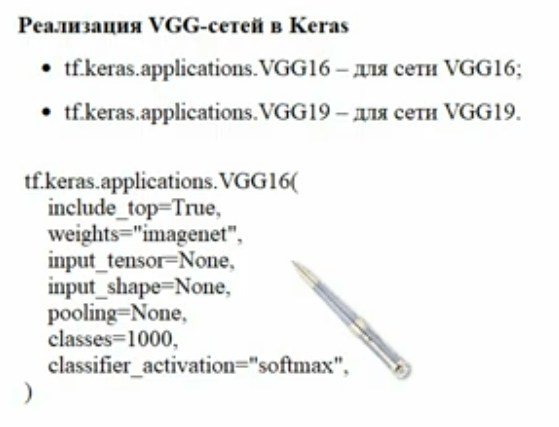

In [ ]:
vgg = Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(IMG_W, IMG_H, CHANNELS)),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(NB_CLASSES, activation='softmax')
])

In [ ]:
vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
vgg.summary()

In [ ]:
vgg_history = vgg.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Про переобучение.

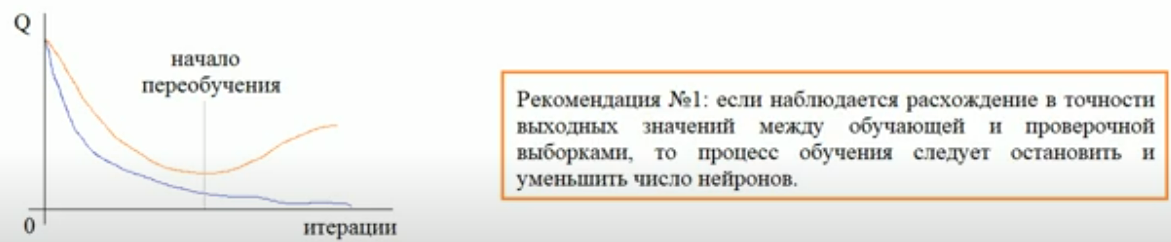

Цель метода dropout $-$ снизить специализацию каждого отдельного нейрона и сделать из каждого специалиста широкого профиля. Выключение некоторых нейронов происходит на каждой итерации изменения весовых коэффициентов.

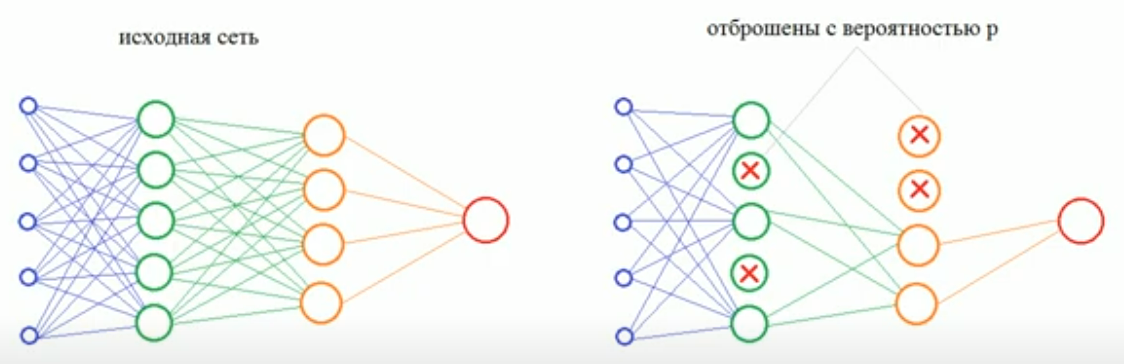

Принцип действия алгоритма dropout показан на следующей иллюстрации.

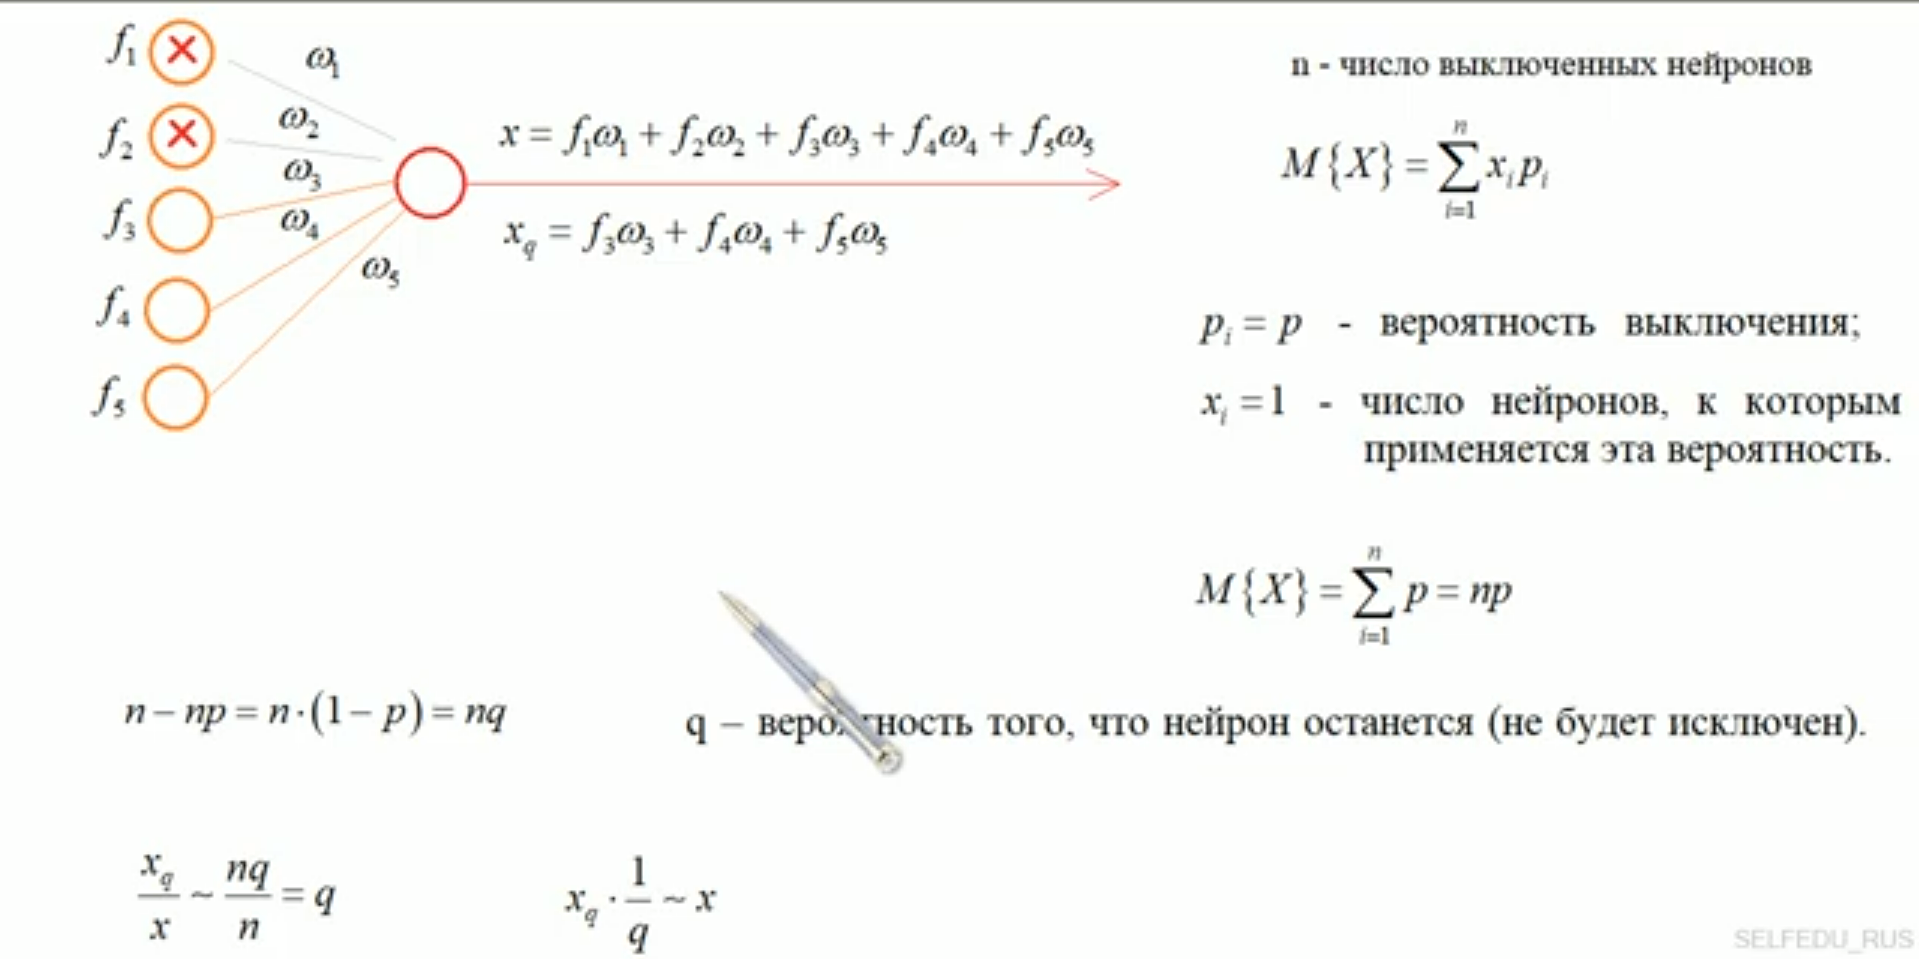

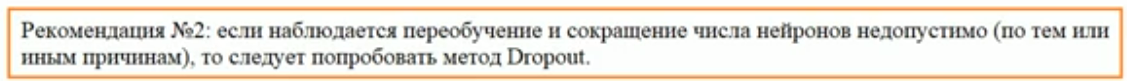

Что рекомендуют авторы подхода для выбора параметра $p$?

Для нейронов скрытого слоя следует начинать с $p = .5$, потом можно попробовать .3 и .4. Dropout применяется к тому слою, после которого стоит. 

Ковариационный сдвиг негативно сказывается на работе НС.

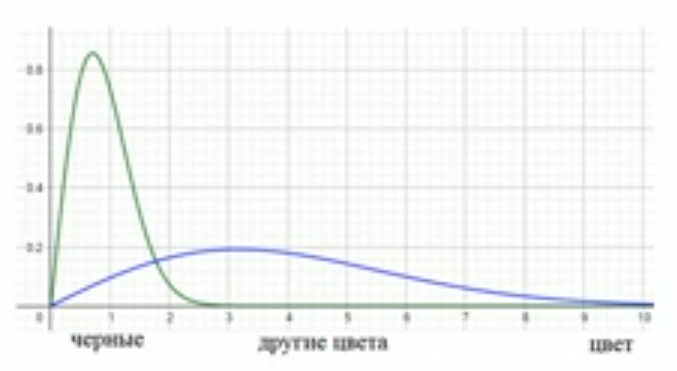

Внутренний ковариационный сдвиг снижает скорость обучения и наклдывает существенные ограничения на шаг сходимости алгоритма градиентного спуска.

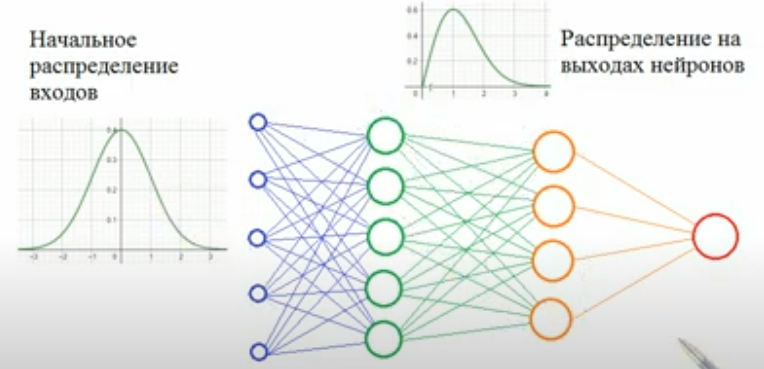

Положительные эффекты использования алгоритма Batch Normalization.

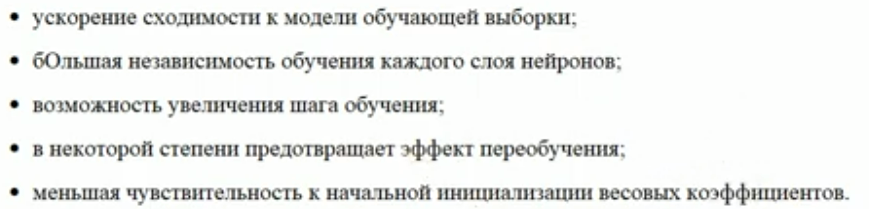

Рекомендации по применению (метод обычно помогает при большом числе слоёв).

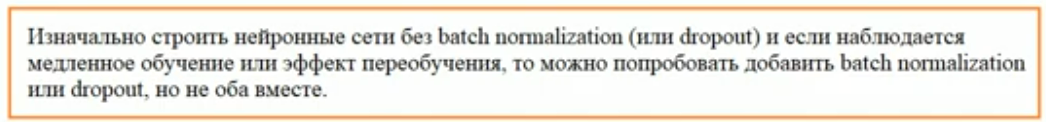

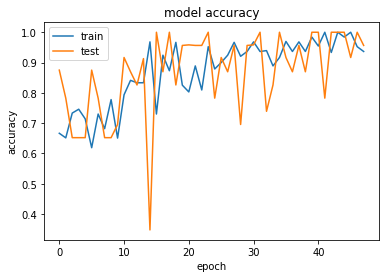

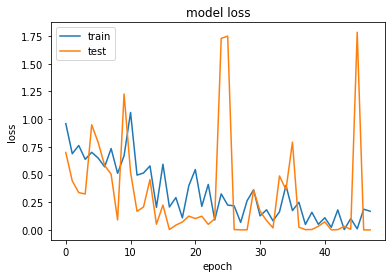

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.93650794
validation_accuracy 0.95652174949646


In [13]:
label = validation_generator.classes

In [14]:
pred= model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{'covid': 0, 'normal': 1}
['covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid']


In [15]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(predicted_class_indices,label)
cf

array([[21,  8],
       [ 0,  0]])

In [16]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted   0  All
Actual            
0          21   21
1           8    8
All        29   29

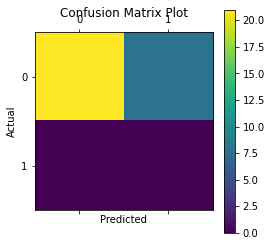

In [17]:
plt.matshow(cf)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();